## UNet

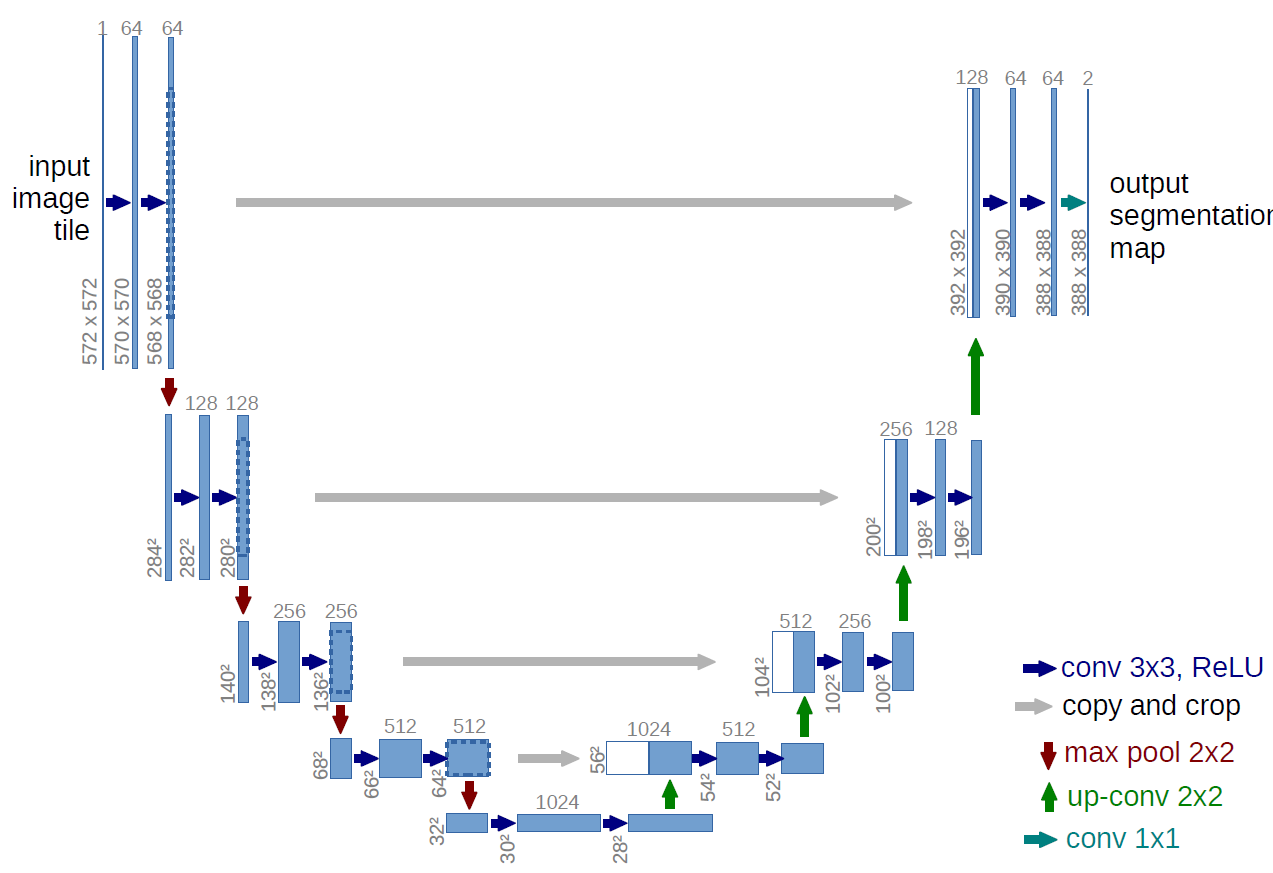

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()  # 初始化父类nn.Module
        self.conv = nn.Sequential(  # 创建包含多个层的神经网络模块
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),  # 添加二维卷积层
            nn.BatchNorm2d(out_channels),  # 添加二维Batch Normalization层
            nn.ReLU(inplace=True),  # 添加ReLU激活函数
            nn.Conv2d(
                out_channels, out_channels, kernel_size=3, padding=1, bias=False
            ),  # 添加二维卷积层
            nn.BatchNorm2d(out_channels),  # 添加二维Batch Normalization层
            nn.ReLU(inplace=True),  # 添加ReLU激活函数
        )

    def forward(self, x):
        return self.conv(x)  # 返回卷积操作后的输出


class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = nn.ModuleList()  # 初始化上采样层
        self.downs = nn.ModuleList()  # 初始化下采样层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化层，用于下采样

        for feature in features:  # 根据features列表中的特征数量，构建下采样的双卷积层
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):  # 根据features列表中的特征数量，构建上采样的转置卷积层和双卷积层
            # self.ups.append(
            #     nn.ConvTranspose2d(
            #         feature * 2, feature, kernel_size=3, stride=1, padding=1
            #     )
            # )
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(in_channels=feature * 2, out_channels=feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)  # 设置中间瓶颈部分的双卷积层
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)  # 输出最终的卷积层

    def forward(self, x):  # 前向传播函数
        skip_connections = []

        for down in self.downs:  # 执行下采样操作，并保存skip connection用于上采样时跳跃连接
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)  # 使用最大池化进行下采样

        x = self.bottleneck(x)  # 进行中间瓶颈部分的卷积操作

        # 除了反转skip connections的方法，还可以采用skip_connections.pop()的方式: 
        # concat_skip = torch.cat((skip_connections.pop(), x), dim=1)
        skip_connections = skip_connections[::-1]  # 将skip connections反转，用于上采样部分的连接

        for idx in range(0, len(self.ups), 2):  # 执行上采样操作
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:  # 若上采样得到的特征图与skip connection的形状不一致，则进行resize操作使它们一致
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)  # 将skip connection和上采样特征图进行拼接
            x = self.ups[idx + 1](concat_skip)  # 经过上采样部分的双卷积操作

        return self.final_conv(x)  # 返回最终的卷积操作得到的特征图

torch.Size([3, 3, 256, 256])
torch.Size([3, 1, 256, 256])


In [5]:
import numpy as np
from torch.utils.data import Dataset
import os
from PIL import Image

import torch.nn as nn
import torch
import torchvision.transforms.functional as TF


class CarvanaDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        # 初始化图像和掩码的目录路径，以及可选的变换
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        # 返回图像的数量
        return len(self.images)

    def __getitem__(self, idx):
        # 根据索引获取图像和对应的掩码
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(
            self.mask_dir, self.images[idx].replace(".jpg", "_mask.gif")
        )

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        if self.transform is not None:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]

        return image, mask

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random

# Hyperparameters

Learning_Rate = 1e-8
Batch_Size = 8
Num_Epochs = 2
Num_Workers = 4
Pin_Memory = True
# Load_Model = False
Device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {Device} device.")

Train_Image_Dir = "./dataset/train"
Train_Mask_Dir = "./dataset/train_mask"
Val_Image_Dir = "./dataset/val"
Val_Mask_Dir = "./dataset/val_mask"

Image_Height = 160
Image_Width = 240

train_losses = []
val_acc = []
val_dice = []

# 设置随机种子
# 设置随机种子以确保结果的可复现性
seed = random.randint(1, 100)
# 设置PyTorch的随机种子
torch.manual_seed(seed)
# 设置PyTorch CUDA的随机种子
torch.cuda.manual_seed(seed)
# 设置PyTorch CUDA所有设备的随机种子
torch.cuda.manual_seed_all(seed)
# 设置NumPy的随机种子
np.random.seed(seed)
# 设置Python内置random模块的随机种子
random.seed(seed)
# 设置PyTorch的cuDNN以保证确定性算法
torch.backends.cudnn.deterministic = True
# 关闭PyTorch的cuDNN的自动寻找最适合当前配置的算法的功能
torch.backends.cudnn.benchmark = False


def train_fn(train_loader, model, loss_fn, optimizer, scaler):
    loop = tqdm(train_loader)
    total_loss = 0.0
    for idx, (data, targets) in enumerate(loop):
        data = data.to(Device)
        targets = targets.unsqueeze(1).float().to(Device)
        
        with torch.cuda.amp.autocast():
            predict = model(data)
            loss = loss_fn(predict, targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(train_loader)


def check_accuracy(loader, model, Device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(Device)
            y = y.unsqueeze(1).to(Device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (2 * (preds * y).sum() + ((preds * y) < 1).sum())
    
    accuracy = round(float(num_correct) / float(num_pixels), 4)
    dice = round(float(dice_score) / float(len(loader)), 4)
    
    print(f"Got {num_correct} / {num_pixels} with accuracy {num_correct/num_pixels*100:.2f}")
    print(f"Dice score is {dice}")
    
    model.train()
    return accuracy, dice
    


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=Image_Height, width=Image_Width),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    
    val_transform = A.Compose(
        [
            A.Resize(height=Image_Height, width=Image_Width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    
    def get_loader(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, train_transform, val_transform, batch_size, num_workers, pin_memory):
        train_ds = CarvanaDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=train_transform)
        val_ds = CarvanaDataset(image_dir=val_image_dir, mask_dir=val_mask_dir, transform=val_transform)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
        val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
        
        return train_loader, val_loader
    
    train_loader, val_loader = get_loader(Train_Image_Dir, Train_Mask_Dir, Val_Image_Dir, Val_Mask_Dir, train_transform, val_transform, Batch_Size, Num_Workers, Pin_Memory)
    
    model = Unet(in_channels=3, out_channels=1).to(Device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)
    scaler = torch.cuda.amp.GradScaler()
    
    for idx in range(Num_Epochs):
        print(f"Epoch {idx+1}/{Num_Epochs}")
        train_loss = train_fn(train_loader, model, loss_fn, optimizer, scaler)
        train_losses.append(train_loss)
        
        accuracy, dice = check_accuracy(val_loader, model, Device)
        val_acc.append(accuracy)
        val_dice.append(dice)


INFO:matplotlib.font_manager:generated new fontManager


Using cuda device.


In [1]:
import torch
import torchvision.transforms.functional as TF
from torch import nn


class DoubleConv(nn.Module):
    """
    Each step in the contraction path and expansive path have two 3x3 convolutional layers followed by ReLU activations.

    In the U-Net paper they used 0 padding, but we use 1 padding so that final feature map is not cropped.
    """

    # in_channels is the number of input channels
    # out_channels is the number of output channels
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # First 3×3 convolutional layer
        self.first = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1
        )
        self.act1 = nn.ReLU()
        # Second 3×3 convolutional layer
        self.second = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
        )
        self.act2 = nn.ReLU()

    # Apply the two convolution layers and activations
    def forward(self, x: torch.Tensor):
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)


class DownSample(nn.Module):
    """
    Down-sample
    Each step in the contracting path down-samples the feature map with a 2x2 max pooling layer.
    """

    def __init__(self):
        super().__init__()

        # 2x2 max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(x)


class UpSample(nn.Module):
    """
    Up-sample
    Each step in the expansive path up-samples the feature map with a 2x2 up-convolution.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        # kernel_size=2, stride=2, 输出特征尺寸为原来的两倍
        self.up = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up(x)


class CropConcat(nn.Module):
    """
    Crop and Concatenate the feature map
    At every step in the expansive path the corresponding feature map from the contracting path concatenated with the current feature map.

    x: current feature map in the expansive path
    contracting_x: corresponding feature map from the contracting path
    """

    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = TF.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps along the channel dimension
        return torch.cat([x, contracting_x], dim=1)


class UNet(nn.Module):
    # in_channels number of channels in the input image
    # out_channels number of channels in the result feature map
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # Double convolution layers for the contracting path. The number of features gets doubled at each step starting from 64.
        self.down_conv = nn.ModuleList(
            [
                DoubleConv(i, o)
                for i, o in zip([in_channels, 64, 128, 256], [64, 128, 256, 512])
            ]
        )
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        # The two convolution layers at the lowest resolution (the bottom of the U)
        self.middle_conv = DoubleConv(512, 1024)
        # Up sampling layers for the expansive path. The number of features is halved with up-sampling
        self.up_sample = nn.ModuleList(
            [UpSample(i, o) for i, o in zip([1024, 512, 256, 128], [512, 256, 128, 64])]
        )
        # Double convolution layers for the expansive path. Their input is the concatenation of the current feature map and the feature map from the contracting path. Therefore, the number of input features is double the number of features from up-sampling.
        self.up_conv = nn.ModuleList(
            [
                DoubleConv(i, o)
                for i, o in zip([1024, 512, 256, 128], [512, 256, 128, 64])
            ]
        )
        # Crop and concatenate layers for the expansive path
        self.concat = nn.ModuleList([CropConcat() for _ in range(4)])
        # Final 1x1 convolutional layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # x: input image
        # pass_through: To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []

        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3×3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3×3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3×3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1×1 convolution layer
        return self.final_conv(x)

# test UNet
x = torch.rand(3, 3, 256, 256)
model = UNet(3, 1)
y = model(x)

print(f"Input shape: {x.shape} \n Output shape: {y.shape}")

Input shape: torch.Size([3, 3, 256, 256]) 
 Output shape: torch.Size([3, 1, 256, 256])


# TransUNet

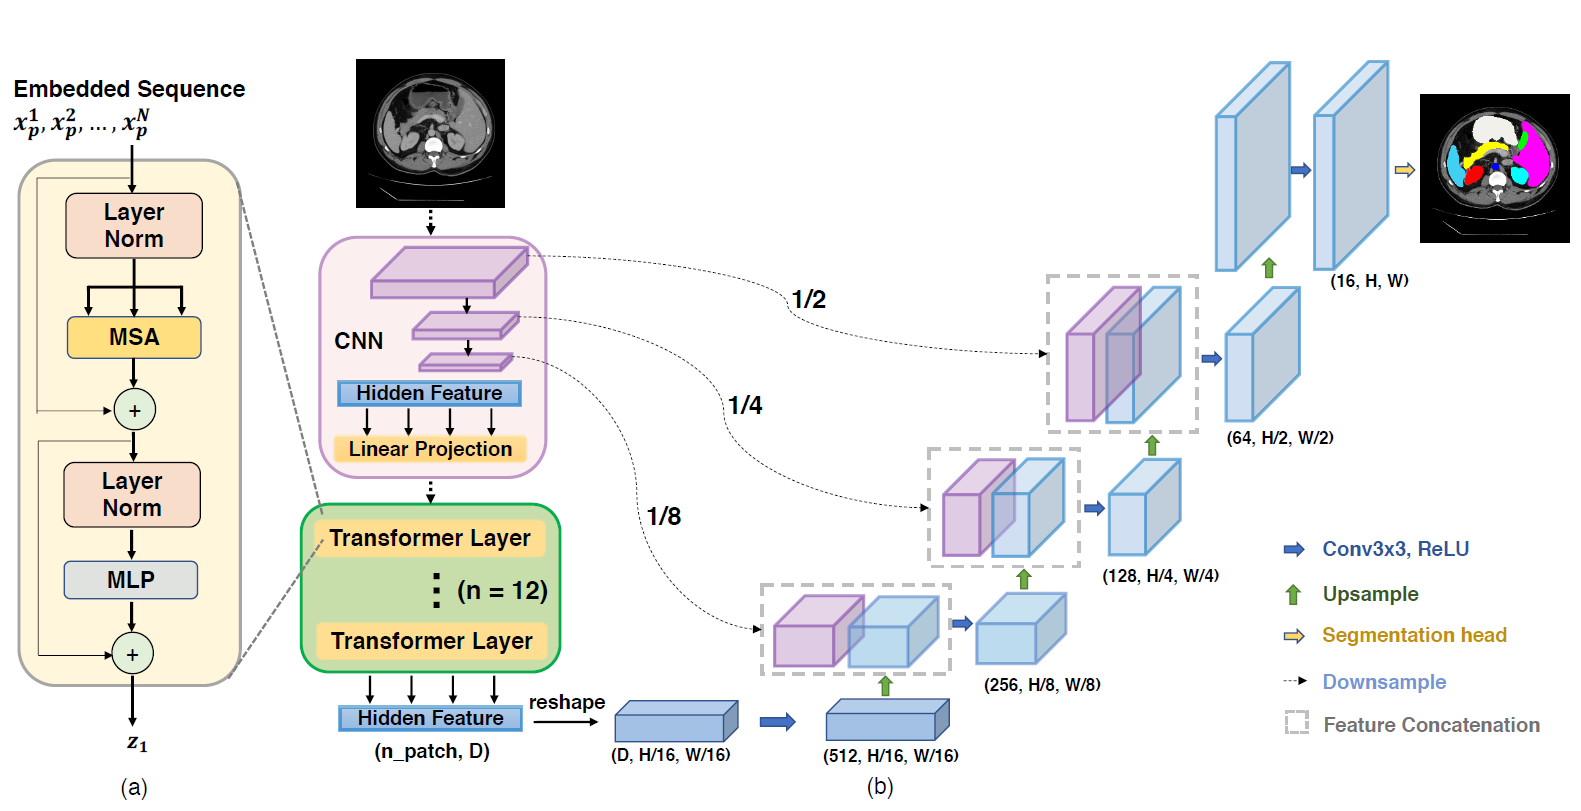

In [1]:
import torch
from torch import nn
from utils.vit import ViT


class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=stride, bias=False
            ),
            nn.BatchNorm2d(out_channels),
        )
        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(
            width, width, kernel_size=3, stride=2, padding=1, dilation=1, bias=False
        )
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)

        x = self.relu(x + x_down)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(
            scale_factor=scale_factor, mode="bilinear", align_corners=True
        )
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride1=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, x_skip=None):
        x = self.upsample(x)

        if x_skip is not None:
            x = torch.cat([x_skip, x], dim=1)

        x = self.layers(x)

        return x


class Encoder(nn.Module):
    def __init__(
        self,
        img_dim,
        in_channels,
        out_channels,
        num_heads,
        mlp_dim,
        num_blocks,
        patch_dim,
        dropout,
        activation,
        num_encoders,
        num_classes,
    ):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit = ViT(
            in_channels=out_channels * 8,
            d_model=out_channels * 8,
            patch_size=patch_dim,
            dropout=dropout,
            num_heads=num_heads,
            activation=activation,
            num_encoders=num_encoders,
            num_classes=num_classes,
        )

        self.conv2 = nn.Conv2d(
            out_channels * 8,
            512,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)

        x = self.vit(x)
        # x = x.permute().flatten(2)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        return x, x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, out_channels, num_classes):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(
            int(out_channels * 1 / 2), int(out_channels * 1 / 8)
        )

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), num_classes, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)
        return x


class TransUnet(nn.Module):

    def __init__(
        self,
        img_dim,
        in_channels,
        out_channels,
        num_heads,
        mlp_dim,
        num_blocks,
        patch_dim,
        dropout,
        activation,
        num_encoders,
        num_classes,
    ):
        super().__init__()

        self.encoder = Encoder(
            img_dim,
            in_channels,
            out_channels,
            num_heads,
            mlp_dim,
            num_blocks,
            patch_dim,
            dropout,
            activation,
            num_encoders,
            num_classes,
        )
        self.decoder = Decoder(out_channels, num_classes)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
transunet = TransUnet(img_dim=128,
                        in_channels=3,
                        out_channels=128,
                        head_num=4,
                        mlp_dim=512,
                        block_num=8,
                        patch_dim=16,
                        class_num=1,).to(device)
x = torch.randn(4, 3, 128, 128).to(device)
pred = transunet(x)
print(pred.shape)